In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.preprocessing import MinMaxScaler  # For data normalization
import matplotlib.pyplot as plt  # For plotting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For model evaluation
import statsmodels.graphics.tsaplots as tsaplots  # For time series analysis plots
from tensorflow.keras.models import Sequential  # For building the LSTM model
from tensorflow.keras.layers import LSTM, Dense  # For LSTM and Dense layers
from statsmodels.tsa.seasonal import seasonal_decompose  # For seasonal decomposition

In [2]:
# Load the Excel file into a DataFrame
df = pd.read_excel('../Data/London_AQI_Daily.xlsx')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Display the first few rows of the DataFrame
df.head()

,Date,USAQI
0,2013-01-02,36
1,2013-01-03,39
2,2013-01-04,34
3,2013-01-05,28
4,2013-01-06,38


In [3]:
df.describe()

,Date,USAQI
count,4441,4441.000000
mean,2019-01-31 00:00:00,47.441792
min,2013-01-02 00:00:00,17.000000
25%,2016-01-17 00:00:00,33.000000
50%,2019-01-31 00:00:00,43.000000
75%,2022-02-14 00:00:00,58.000000
max,2025-02-28 00:00:00,155.000000
std,NaN,19.187606


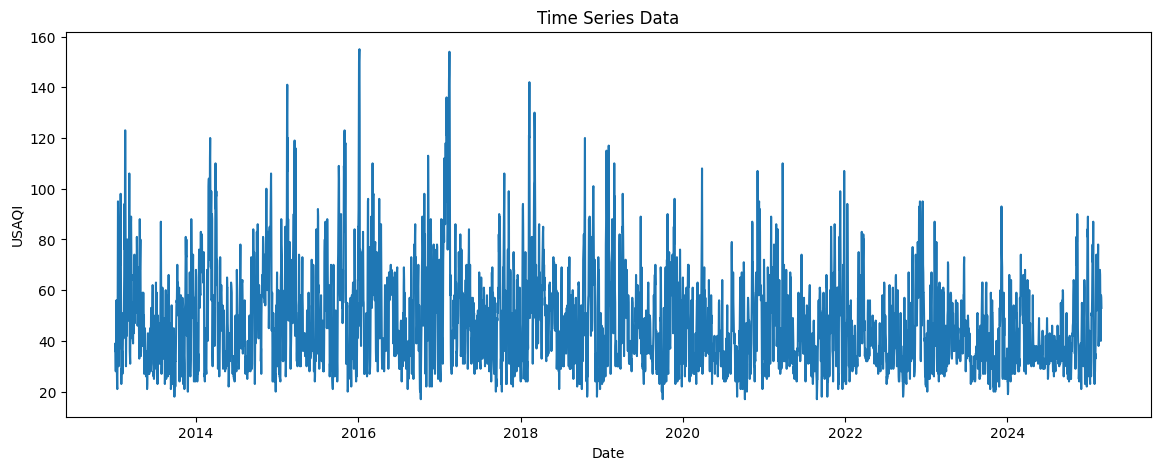

<Figure size 1400x500 with 0 Axes>

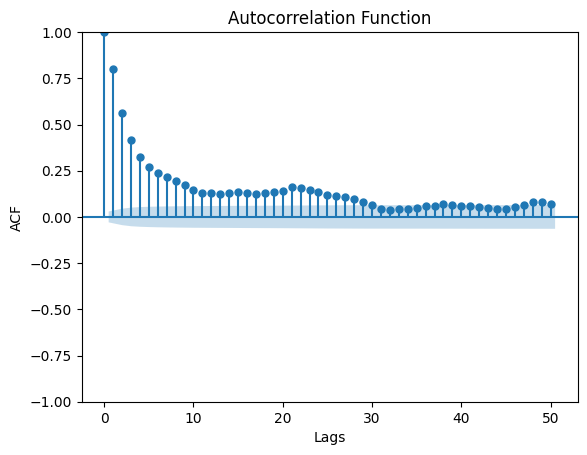

<Figure size 1400x500 with 0 Axes>

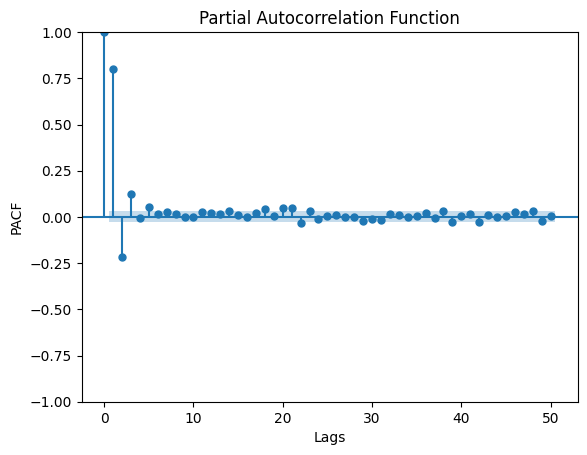

In [4]:
# Plot the time series data
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['USAQI'])
plt.xlabel('Date')
plt.ylabel('USAQI')
plt.title('Time Series Data')
plt.show()

# Plot ACF
plt.figure(figsize=(14, 5))
tsaplots.plot_acf(df['USAQI'], lags=50)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 5))
tsaplots.plot_pacf(df['USAQI'], lags=50)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')
plt.show()

<Figure size 1400x1000 with 0 Axes>

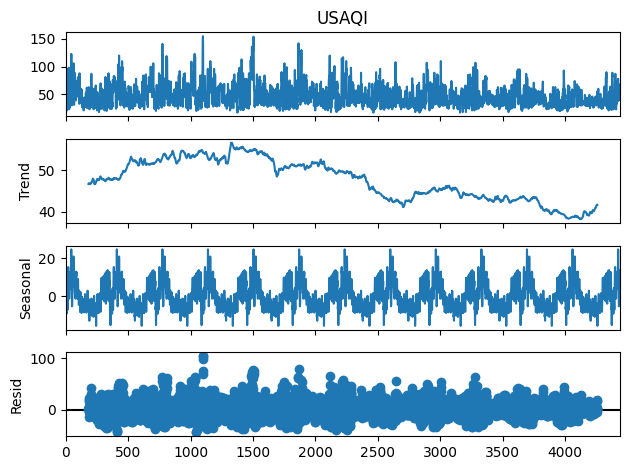

In [5]:
# Perform seasonal decomposition
result = seasonal_decompose(df['USAQI'], model='additive', period=365)

# Plot the seasonal decomposition
plt.figure(figsize=(14, 10))
result.plot()
plt.show()

In [6]:
# Split the data into training and testing sets
train_df = df[(df['Date'] >= '2013-01-02') & (df['Date'] <= '2024-10-30')]
test_df = df[(df['Date'] >= '2024-10-31') & (df['Date'] <= '2025-02-28')]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['USAQI']])
test_scaled = scaler.transform(test_df[['USAQI']])

In [7]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Sequence length
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=5)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/5


c:\Users\John\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4260/4260 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.0119
Epoch 2/5
4260/4260 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0072
Epoch 3/5
4260/4260 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - loss: 0.0069
Epoch 4/5
4260/4260 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0071
Epoch 5/5
4260/4260 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0069
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


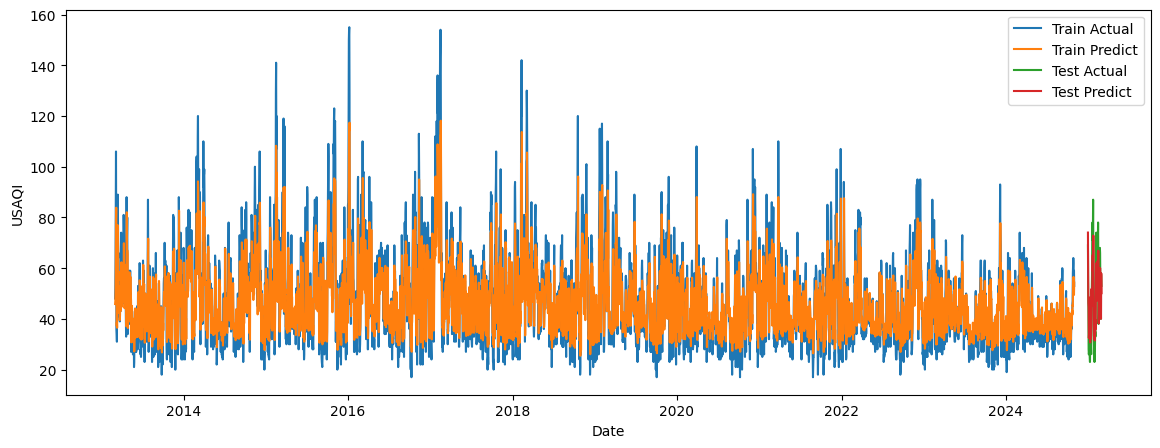

In [8]:
# Plot the results

plt.figure(figsize=(14, 5))
plt.plot(train_df['Date'][seq_length:], y_train, label='Train Actual')
plt.plot(train_df['Date'][seq_length:], train_predict, label='Train Predict')
plt.plot(test_df['Date'][seq_length:], y_test, label='Test Actual')
plt.plot(test_df['Date'][seq_length:], test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('USAQI')
plt.legend()
plt.show()

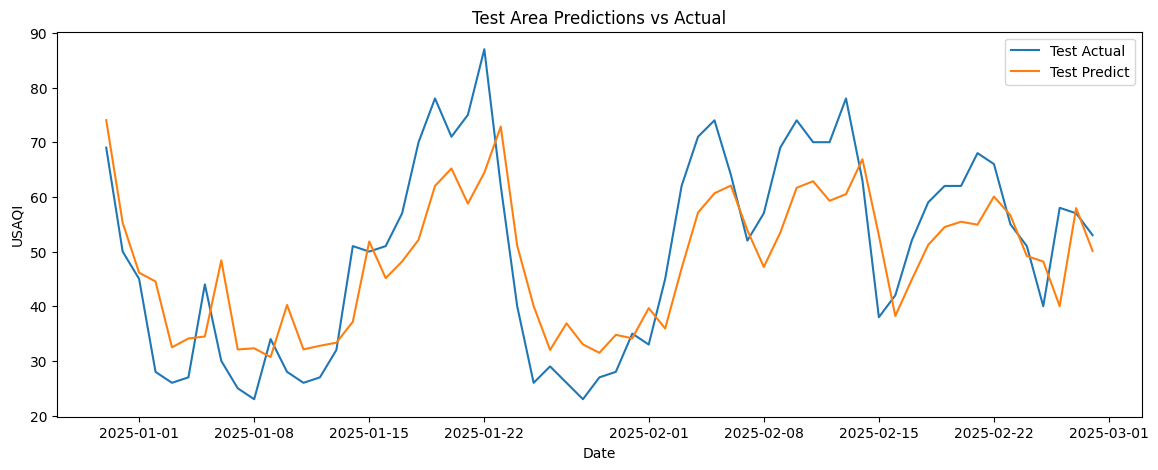

In [9]:
# Plot test area predictions vs actual 

plt.figure(figsize=(14, 5))
plt.plot(test_df['Date'][seq_length:], y_test, label='Test Actual')
plt.plot(test_df['Date'][seq_length:], test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('USAQI')
plt.legend()
plt.title('Test Area Predictions vs Actual')
plt.show()

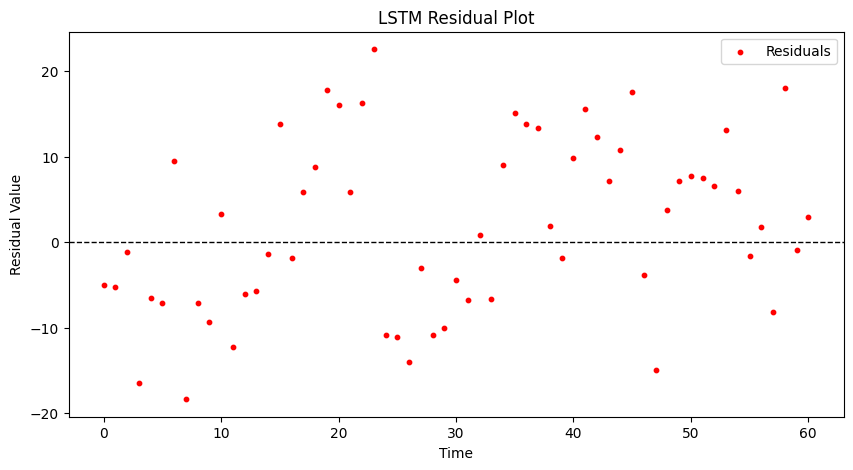

In [10]:
residuals = y_test - test_predict  # Compute residuals

plt.figure(figsize=(10,5))
plt.scatter(range(len(residuals)), residuals, label="Residuals", color='red', s=10)  # Dot plot of residuals
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)  # Reference line at 0
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.title("LSTM Residual Plot")
plt.legend()
plt.show()

In [11]:
# Calculate RMSE for train and test
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# Calculate MAE for train and test
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

Train RMSE: 11.439195162143198
Test RMSE: 10.251338631768636
Train MAE: 8.781625830959266
Test MAE: 8.761935499847912


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for train and test
train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')

Train MAPE: 19.586628509858535
Test MAPE: 19.566288478498144


In [13]:
# Naive persistence model predictions
naive_predict = test_df['USAQI'].shift(1).dropna().values

# Align the actual values to match the shifted predictions
actual_values = test_df['USAQI'][1:].values

# Calculate RMSE for naive persistence model
naive_rmse = np.sqrt(mean_squared_error(actual_values, naive_predict))

# Calculate MAE for naive persistence model
naive_mae = mean_absolute_error(actual_values, naive_predict)

# Calculate MAPE for naive persistence model
naive_mape = mean_absolute_percentage_error(actual_values, naive_predict)

print(f'Naive Persistence Model RMSE: {naive_rmse}')
print(f'Naive Persistence Model MAE: {naive_mae}')
print(f'Naive Persistence Model MAPE: {naive_mape}')

Naive Persistence Model RMSE: 10.67551716155553
Naive Persistence Model MAE: 8.416666666666666
Naive Persistence Model MAPE: 19.211344075675775
